In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

In [9]:
train = pd.read_csv('./train.csv')
# sub = pd.read_csv('./sample_submission.csv')

In [10]:
# # fake test (가상데이터 실험시 아래꺼 주석풀고 활성화)
# answers = train.loc[train[(train['month']==8)&(train['year']==2025)].index]
# train = train.drop(train[(train['month']==8)&(train['year']==2025)].index)
# train

## Step 1: 월별 시계열 데이터 생성

In [11]:
monthly = train.groupby(['item_id', 'year', 'month']).agg({
    'value': 'sum',
    'weight': 'sum',
    'quantity': 'sum',
    'hs4': 'first'
}).reset_index()

monthly['year_month'] = pd.to_datetime(
    monthly['year'].astype(str) + '-' + monthly['month'].astype(str),
    format='%Y-%m'
)

pivot_value = monthly.pivot_table(
    index='year_month',
    columns='item_id',
    values='value',
    fill_value=0
).sort_index()

# Transpose: item을 index로 (예시 코드 형식)
pivot = pivot_value.T  # (100 items × 43 months)

pivot.head(5)

year_month,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


In [12]:
item_to_hs4 = monthly.groupby('item_id')['hs4'].first().to_dict()

## Step 1.1: STL분해 및 residual only 패턴

In [13]:
from statsmodels.tsa.seasonal import STL

# ==============================
# STL residual pivot 만들기
# ==============================

def extract_residual(series, period=12):
    """
    pivot.loc[item_id] 1개 시계열을 받아 residual만 반환
    """
    s = pd.Series(series)

    # 0 → NaN 처리 후 보간
    s = s.replace(0, np.nan).interpolate().fillna(method="bfill").fillna(method="ffill")

    stl = STL(s, period=period, robust=True).fit()
    return stl.resid

# residual pivot 생성
residual_pivot = pd.DataFrame(
    {
        item: extract_residual(pivot.loc[item])
        for item in pivot.index
    }
).T

print("원본 pivot:", pivot.shape)
print("Residual pivot:", residual_pivot.shape)

/tmp/ipython-input-246712618.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.replace(0, np.nan).interpolate().fillna(method="bfill").fillna(method="ffill")


원본 pivot: (100, 43)
Residual pivot: (100, 43)


In [ ]:
pivot.to_csv("pivot.csv",index=None,encoding='utf-8-sig')
residual_pivot.to_csv("residual_pivot.csv",index=None,encoding='utf-8-sig')

In [ ]:
residual_pivot.head()

year_month,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
G_ITEM001,-1.756606e-06,-1.373115e-06,-1.002496e-06,1.181475e-06,1.501658e-06,2.985433e-08,3.453783e-07,6.446653e-07,9.207266e-07,1.516037e-06,...,9.130598e-07,7.307936e-07,5.784642e-07,6.482807e-08,-1.275962e-07,-3.267458e-07,9.074854e-07,6.212275e-07,-9.606485e-07,-1.183554e-06
G_ITEM002,-2.327738e-11,-1.371347e-11,-5.108802e-12,2.621903e-12,9.507062e-12,1.554668e-11,2.068390e-11,2.447820e-11,2.577494e-11,2.137668e-11,...,-3.645611e-08,-3.186486e-08,-2.613079e-08,-1.968218e-08,-1.270689e-08,-1.996055e-02,2.488093e-09,1.061792e-08,1.906176e-08,2.779139e-08
G_ITEM003,-5.521247e-03,-3.904656e-03,-2.294005e-03,-6.908581e-04,9.026834e-04,2.483566e-03,4.047177e-03,5.589420e-03,1.487802e-02,8.528188e-03,...,4.973117e-03,4.124251e-03,5.231061e-03,2.290176e-03,1.339070e-03,3.724918e-04,-6.060434e-04,-1.594239e-03,-2.590520e-03,-3.593668e-03


In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- 월 리스트 (나중에 Step 7에서도 씀) ---
months_dt = pivot.columns.to_list()

# === STL 분해 기반 trend_pivot, seasonal_pivot 생성 ===
trend_data = {}
seasonal_data = {}

for item_id in pivot.index:
    series = pivot.loc[item_id].astype(float)
    series_clean = series.fillna(0)

    try:
        decomposition = seasonal_decompose(series_clean, model='additive', period=12)
        trend_data[item_id] = decomposition.trend
        seasonal_data[item_id] = decomposition.seasonal
    except Exception as e:
        # 실패 시 NaN으로 채움
        trend_data[item_id] = pd.Series([np.nan] * len(series_clean), index=series_clean.index)
        seasonal_data[item_id] = pd.Series([np.nan] * len(series_clean), index=series_clean.index)

trend_pivot = pd.DataFrame(trend_data).T
seasonal_pivot = pd.DataFrame(seasonal_data).T

print("trend_pivot 및 seasonal_pivot 생성 완료.")

trend_pivot 및 seasonal_pivot 생성 완료.


# Step 1.2: Seasonal Weight 8월 위주 공행성 가중판단

In [36]:
# # ============================================================
# # (NEW) 시즌 가중치: 6, 7, 8월 + 마지막 해의 여름에 더 큰 weight
# # ============================================================
# def build_month_weights(months, season_months=(6, 7, 8)):
#     """
#     months: pivot.columns (DatetimeIndex)
#     season_months: 여름 시즌으로 볼 달 번호 튜플
#     반환: 각 month별 weight (float)
#     """
#     months = pd.to_datetime(months)
#     base_w = np.ones(len(months), dtype=float)

#     month_nums = np.array([m.month for m in months])
#     year_nums  = np.array([m.year  for m in months])

#     # 1) 모든 해에서 6,7,8월이면 기본 2배
#     season_mask = np.isin(month_nums, season_months)
#     base_w[season_mask] *= 2.0

#     # 2) 마지막 해의 6,7,8월은 추가로 1.5배 (총 3배 효과)
#     last_year = months[-1].year
#     last_season_mask = season_mask & (year_nums == last_year)
#     base_w[last_season_mask] *= 1.5

#     return base_w

# month_weights = build_month_weights(months_dt)
# print("month_weights:", month_weights)

# ============================================================
# (NEW) Recency-based month weights
#   - 최근 6개월: 3배
#   - 최근 12개월: 2배
#   - 그 전: 1배
# ============================================================
def build_recency_weights(months, w_recent6=3.0, w_recent12=2.0):
    """
    months: DatetimeIndex
    """
    n = len(months)
    base_w = np.ones(n, dtype=float)

    # index 기반 (최근일수록 index가 큼)
    # 마지막 index = n-1

    # 최근 6개월: weight = 3
    recent6_idx = np.arange(n-6, n)
    recent6_idx = recent6_idx[recent6_idx >= 0]
    base_w[recent6_idx] = w_recent6

    # 최근 12개월: weight = 2 (단, 최근6은 이미 3으로 올라가 있으므로 별도 처리 없음)
    recent12_idx = np.arange(n-12, n)
    recent12_idx = recent12_idx[recent12_idx >= 0]
    # 아직 3배가 아닌 곳만 2배로 설정
    for i in recent12_idx:
        if base_w[i] == 1.0:
            base_w[i] = w_recent12

    return base_w

month_weights = build_recency_weights(months_dt)
print("month_weights:", month_weights)

month_weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3. 3. 3.]


In [37]:
# # ============================================================
# # (NEW) 시즌 가중 상관계수
# # ============================================================
# def season_weighted_corr(x, y, lag, month_weights):
#     """
#     x, y: 전체 시계열 (numpy 1D)
#     lag: follower가 leader보다 lag개월 뒤
#     month_weights: months_dt 기준 weight 벡터

#     상관계수는 (x[:-lag], y[lag:]) 구간에 대해서
#     leader쪽 달 / follower쪽 달 weight를 평균내서 사용.
#     """
#     n = len(month_weights)
#     if lag <= 0 or n <= lag:
#         return 0.0

#     a = np.asarray(x[:-lag], dtype=float)
#     b = np.asarray(y[lag:], dtype=float)

#     if len(a) != len(b):
#         return 0.0

#     # leader 달 / follower 달의 weight를 모두 고려해서 평균
#     w_lead = month_weights[:-lag]
#     w_foll = month_weights[lag:]
#     w = (w_lead + w_foll) / 2.0
#     w = np.clip(w, 1e-6, None)

#     w_norm = w / w.sum()

#     a_mean = np.sum(a * w_norm)
#     b_mean = np.sum(b * w_norm)

#     a_c = a - a_mean
#     b_c = b - b_mean

#     num = np.sum(w * a_c * b_c)
#     denom = np.sqrt(np.sum(w * a_c**2) * np.sum(w * b_c**2))
#     if denom == 0:
#         return 0.0

#     return float(num / denom)

# ============================================================
# (NEW) recency-weighted correlation
# ============================================================
def recency_weighted_corr(x, y, lag, month_weights):
    """
    x, y: 전체 raw series
    lag: follower가 leader보다 lag개월 뒤
    """
    n = len(month_weights)
    if lag <= 0 or n <= lag:
        return 0.0

    a = np.asarray(x[:-lag], dtype=float)
    b = np.asarray(y[lag:], dtype=float)

    if len(a) != len(b):
        return 0.0

    # leader / follower month weight 평균
    w_lead = month_weights[:-lag]
    w_foll = month_weights[lag:]
    w = (w_lead + w_foll) / 2.0

    w = np.clip(w, 1e-6, None)
    w_norm = w / w.sum()

    a_mean = np.sum(a * w_norm)
    b_mean = np.sum(b * w_norm)

    a_c = a - a_mean
    b_c = b - b_mean

    num   = np.sum(w * a_c * b_c)
    denom = np.sqrt(np.sum(w * a_c**2) * np.sum(w * b_c**2))

    if denom == 0:
        return 0.0
    return float(num / denom)

## Step 2: HS4 매핑 및 유사도 함수

In [ ]:
# # 2-1. 품목별 HS4 매핑
# item_to_hs4 = monthly.groupby('item_id')['hs4'].first().to_dict()

# def hs4_similarity(item_a, item_b):
#     """
#     HS4 코드 앞자리 유사도 계산
#     예: 8471 vs 8473 -> 2자리 일치 -> 0.5
#     """
#     str_a = str(item_a).zfill(4)
#     str_b = str(item_b).zfill(4)

#     if str_a[:2] == str_b[:2]:  # 2자리 일치
#         return 0.5
#     elif str_a[:1] == str_b[:1]:  # 1자리 일치
#         return 0.3
#     return 0.0

## Step 3: 통계적 유의성 검증

In [18]:
from scipy.stats import pearsonr

def safe_corr_with_pvalue(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0, 1.0
    corr, p_value = pearsonr(x, y)
    return float(corr), float(p_value) # 피어슨 상관계수, p-value

## Step 4: Granger Causality 검증

- A의 과거 정보가 B의 미래를 예측하는 데 도움이 되는가?"**를 통계적으로 검증하는 방법



```
# B의 과거 + A의 과거 사용
B(3월) = f(B의 1월, B의 2월, A의 1월, A의 2월)
B(4월) = f(B의 2월, B의 3월, A의 2월, A의 3월)
...

예측 오차 = 2  ← 더 정확!
```

**결론**
```
A의 정보를 추가했더니 예측이 더 정확해짐!
→ "A가 B를 Granger-cause 한다" ✅
```

---

🔬 통계적 검증

**가설 검정**
```
H0 (귀무가설): A의 과거 정보는 B 예측에 도움 안 됨
H1 (대립가설): A의 과거 정보는 B 예측에 도움 됨

→ F-test로 검증
→ p-value < 0.05 이면 H0 기각 → A가 B를 cause함!
```



In [19]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_test(x, y, max_lag=6):
    """
    x가 y를 Granger-cause 하는지 검증
    """
    try:
        data = pd.DataFrame({'x': x, 'y': y})
        test_result = grangercausalitytests(data[['y', 'x']],
                                            maxlag=max_lag,
                                            verbose=False)
        # 각 lag의 p-value 중 최소값 반환
        p_values = [test_result[lag][0]['ssr_ftest'][1]
                   for lag in range(1, max_lag+1)]
        return min(p_values)
    except:
        return 1.0


## Step 5: 공행성 강도 점수 계산

In [20]:
def calculate_score_advanced(corr, p_value, granger_p, lag):
    """
    정교한 공행성 점수 계산
    """

    # 1. 상관계수 점수 (0~50점) - 비선형 스케일링
    # 강한 상관관계에 더 높은 보상
    if abs(corr) >= 0.8:
        corr_score = 50
    elif abs(corr) >= 0.7:
        corr_score = 45
    elif abs(corr) >= 0.6:
        corr_score = 38
    elif abs(corr) >= 0.5:
        corr_score = 30
    else:
        corr_score = abs(corr) * 50  # 0.5 미만은 선형

    # 2. 통계적 유의성 점수 (0~25점) - 더 세분화
    if p_value < 0.001:
        sig_score = 25  # 매우 강한 유의성
    elif p_value < 0.01:
        sig_score = 20
    elif p_value < 0.05:
        sig_score = 12
    else:
        sig_score = 5  # 약한 유의성도 약간 점수

    # 3. Granger 인과성 점수 (0~20점) - 더 세분화
    if granger_p < 0.001:
        granger_score = 20  # 매우 강한 인과성
    elif granger_p < 0.01:
        granger_score = 16
    elif granger_p < 0.05:
        granger_score = 10
    elif granger_p < 0.10:
        granger_score = 5  # 약한 인과성
    else:
        granger_score = 0

    # 4. Lag 점수 (0~5점) - 비선형, 너무 짧거나 긴 lag 패널티
    # 최적 lag는 2-3개월로 가정
    if lag == 2 or lag == 3:
        lag_score = 5  # 최적
    elif lag == 1 or lag == 4:
        lag_score = 4  # 양호
    elif lag == 5:
        lag_score = 2  # 보통
    else:  # lag >= 6
        lag_score = 0  # 너무 김

    total_score = corr_score + sig_score + granger_score + lag_score

    return total_score

## Step 6: 각 Leading별 Following 탐지

In [38]:
from tqdm import tqdm

def find_comovement_pairs(
    pivot,
    max_lag=6,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=40,
    month_weights=None,
    season_alpha=0.7,   # 시즌 가중 비중 (0.7 = 시즌 70%, 전체 30%)
):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), total=len(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        candidates = []

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            # best_corr = 0.0
            best_corr_raw = 0.0          # 전체 기간 raw corr (그대로 max_corr에 저장)
            best_corr_season = 0.0       # 시즌 가중 corr (설명용 / 디버깅용)
            best_corr_mixed = 0.0        # 최종 점수용 corr
            best_p_value = 1.0

            # lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue

                # 1) 전체 기간 상관
                corr_raw, p_value = safe_corr_with_pvalue(x[:-lag], y[lag:])

                # 2) 시즌 가중 상관
                if month_weights is not None:
                    corr_season = recency_weighted_corr(x, y, lag, month_weights)
                    # 시즌 비중 season_alpha, 전체 corr 비중 (1 - season_alpha)
                    corr_mixed = season_alpha * corr_season + (1.0 - season_alpha) * corr_raw
                else:
                    corr_season = corr_raw
                    corr_mixed = corr_raw

                # 3) |corr_mixed| 기준으로 best lag 선택
                if abs(corr_mixed) > abs(best_corr_mixed):
                    best_corr_mixed = corr_mixed
                    best_corr_raw = corr_raw
                    best_corr_season = corr_season
                    best_p_value = p_value
                    best_lag = lag

            # 기본 임계값 통과 시
            if best_lag is not None and abs(best_corr_mixed) >= corr_threshold:
                # Granger test
                granger_p = granger_test(x, y, max_lag=best_lag)

                # 종합 점수 계산
                score = calculate_score_advanced(
                    best_corr_mixed, # 여기만 corr_raw → corr_mixed
                    best_p_value, granger_p, best_lag
                )

                # 점수 임계값 통과 시 후보에 추가
                if score >= score_threshold:
                    candidates.append({
                        "following_item_id": follower,
                        "best_lag": best_lag,
                        "max_corr": best_corr_raw,
                        "p_value": best_p_value,
                        "granger_p_value": granger_p,
                        "comovement_score": score,
                    })

        # 알파벳 순으로 정렬
        candidates.sort(key=lambda x: x['following_item_id'])

        for candidate in candidates:
            results.append({
                "leading_item_id": leader,
                "following_item_id": candidate["following_item_id"],
                "best_lag": candidate["best_lag"],
                "max_corr": candidate["max_corr"]
            })

    pairs = pd.DataFrame(results)
    return pairs

# # 실행
# pairs = find_comovement_pairs(pivot,9,12,0.4,35)
# print("탐색된 공행성쌍 수:", len(pairs))
# pairs.head(20)

# Step 6.1: pair plot하기 (원본 및 잔차)

In [22]:
import matplotlib.pyplot as plt

# (A) raw plot
def plot_raw_pair(item_a, item_b, pivot):
    plt.figure(figsize=(10,4))
    plt.plot(pivot.columns, pivot.loc[item_a], marker='o', label=f"{item_a} (raw)")
    plt.plot(pivot.columns, pivot.loc[item_b], marker='o', label=f"{item_b} (raw)")
    plt.title(f"[RAW] {item_a} → {item_b}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# (B) residual plot
def plot_resid_pair(item_a, item_b, residual_pivot):
    plt.figure(figsize=(10,4))
    plt.plot(residual_pivot.columns, residual_pivot.loc[item_a], marker='o',
             label=f"{item_a} (residual)")
    plt.plot(residual_pivot.columns, residual_pivot.loc[item_b], marker='o',
             label=f"{item_b} (residual)")
    plt.title(f"[RESIDUAL] {item_a} → {item_b}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

#(C) raw + residual 둘 다 한 번에 보여주는 plot 함수
def plot_raw_and_residual_save(a, b, pivot, residual_pivot, save_dir):
    """
    raw + residual 두 개의 개별 plot을 하나의 파일로 저장
    """

    # 폴더 없으면 생성
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    # 1) 원본 raw plot
    axes[0].plot(pivot.columns, pivot.loc[a], marker='o', label=f'{a} (raw)')
    axes[0].plot(pivot.columns, pivot.loc[b], marker='o', label=f'{b} (raw)')
    axes[0].set_title(f'[RAW] {a} vs {b}')
    axes[0].grid(True)
    axes[0].legend()

    # 2) residual plot
    axes[1].plot(residual_pivot.columns, residual_pivot.loc[a], marker='o',
                 label=f'{a} (residual)')
    axes[1].plot(residual_pivot.columns, residual_pivot.loc[b], marker='o',
                 label=f'{b} (residual)')
    axes[1].set_title(f'[RESIDUAL] {a} vs {b}')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()

    # 저장 파일명
    file_name = f"{a}__{b}.png"
    save_path = os.path.join(save_dir, file_name)

    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"저장 완료 → {save_path}")

In [40]:
pairs = find_comovement_pairs(
    pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.35,
    score_threshold=45,
    month_weights=month_weights,
    season_alpha=0.5,   # 최신의 영향력 50%, 전체 히스토리 50%
)

pairs_resid = find_comovement_pairs(
    residual_pivot,
    max_lag=9,
    min_nonzero=12,
    corr_threshold=0.35,
    score_threshold=45,
    month_weights=month_weights,
    season_alpha=0.5,
)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated si

In [41]:
pairs.to_csv("pairs(hs_251118_2).csv",encoding='utf-8-sig',index=None)
pairs_resid.to_csv("pairs_resid(hs_251118_2).csv",encoding='utf-8-sig',index=None)

In [25]:
import os

SAVE_DIR = "plots_raw_pairs"   # 원하는 폴더명

# 🔥 raw 기준 pairs를 plot
N = 20  # 원하는 개수만큼 plot

for i in range(min(N, len(pairs))):
    row = pairs.iloc[i]
    a = row["leading_item_id"]
    b = row["following_item_id"]

    plot_raw_and_residual_save(a, b, pivot, residual_pivot, SAVE_DIR)

저장 완료 → plots_raw_pairs/AANGBULD__APQGTRMF.png
저장 완료 → plots_raw_pairs/AANGBULD__DDEXPPXU.png
저장 완료 → plots_raw_pairs/AANGBULD__DEWLVASR.png
저장 완료 → plots_raw_pairs/AANGBULD__ELQGMQWE.png
저장 완료 → plots_raw_pairs/AANGBULD__FTSVTTSR.png
저장 완료 → plots_raw_pairs/AANGBULD__GKQIJYDH.png
저장 완료 → plots_raw_pairs/AANGBULD__GYHKIVQT.png
저장 완료 → plots_raw_pairs/AANGBULD__KJNSOAHR.png
저장 완료 → plots_raw_pairs/AANGBULD__LLHREMKS.png
저장 완료 → plots_raw_pairs/AANGBULD__LTOYKIML.png
저장 완료 → plots_raw_pairs/AANGBULD__NAQIHUKZ.png
저장 완료 → plots_raw_pairs/AANGBULD__OKMBFVKS.png
저장 완료 → plots_raw_pairs/AANGBULD__OXKURKXR.png
저장 완료 → plots_raw_pairs/AANGBULD__QVLMOEYE.png
저장 완료 → plots_raw_pairs/AANGBULD__UQYUIVVR.png
저장 완료 → plots_raw_pairs/AANGBULD__VUAFAIYJ.png
저장 완료 → plots_raw_pairs/AANGBULD__XIIEJNEE.png
저장 완료 → plots_raw_pairs/AANGBULD__ZCELVYQU.png
저장 완료 → plots_raw_pairs/AANGBULD__ZKENOUDA.png
저장 완료 → plots_raw_pairs/AANGBULD__ZXERAXWP.png


In [42]:
# 🚀 4. (옵션) 두 결과 차이 비교 (교집합/차집합)
raw_set = set((r.leading_item_id, r.following_item_id) for _, r in pairs.iterrows())
resid_set = set((r.leading_item_id, r.following_item_id) for _, r in pairs_resid.iterrows())

common_pairs = raw_set & resid_set
raw_only = raw_set - resid_set
resid_only = resid_set - raw_set

print("공통쌍:", len(common_pairs))
print("raw only:", len(raw_only))
print("residual only:", len(resid_only))

공통쌍: 750
raw only: 919
residual only: 2817


In [43]:
# 🔹 여기서부터: df_meta 대신, pairs_raw만 사용 + f_is_common만 추가
# f_is_common: raw & resid 모두에 등장하는 교집합 쌍이면 1, 아니면 0
pairs['f_is_common'] = pairs.apply(
    lambda r: 1 if (r['leading_item_id'], r['following_item_id']) in common_pairs else 0,
    axis=1
)

print("pairs에 f_is_common 추가 완료. shape:", pairs.shape)

pairs에 f_is_common 추가 완료. shape: (1669, 5)


# Step 7 STL활용, 새로운 meta feature활용한 value예측

100%|██████████| 6/6 [00:00<00:00, 312.07it/s]

생성된 학습 데이터의 shape : (235, 11)
LGBMRegressor 모델(7개 feature) 학습 시작...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 168
[LightGBM] [Info] Number of data points in the train set: 235, number of used features: 7
[LightGBM] [Info] Start training from score 30.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

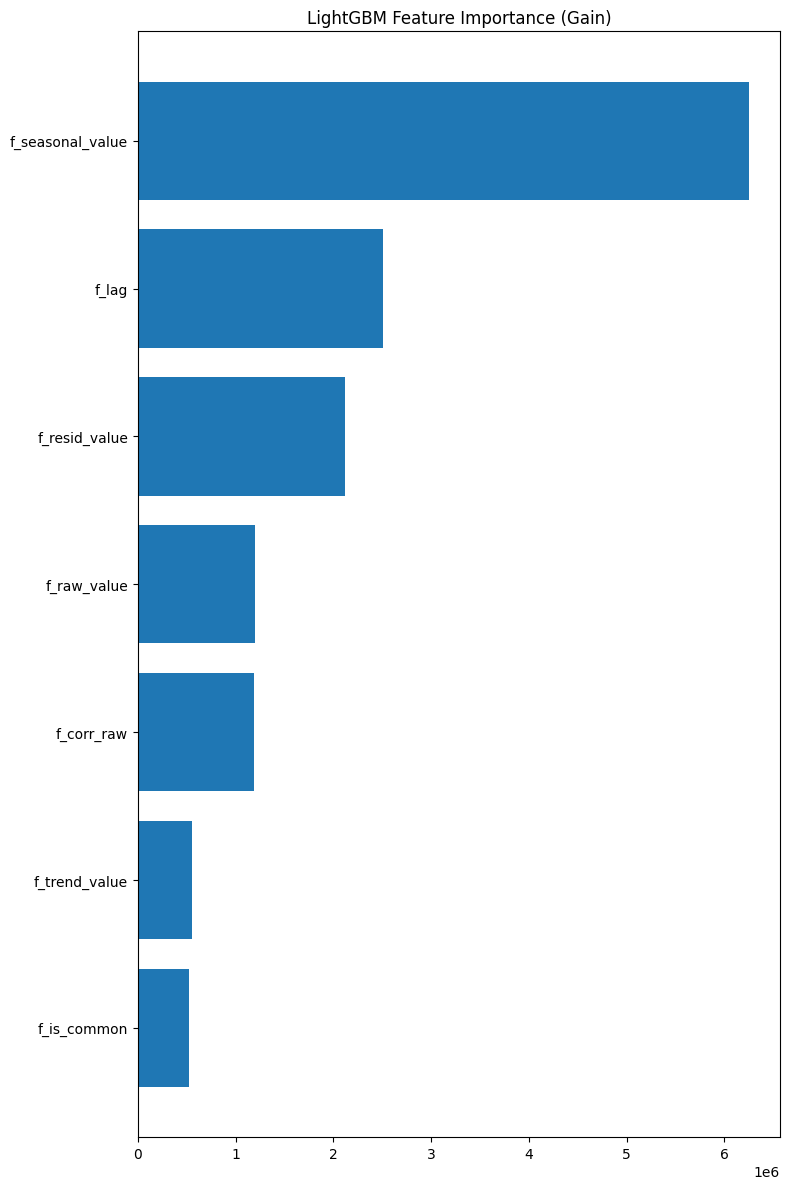

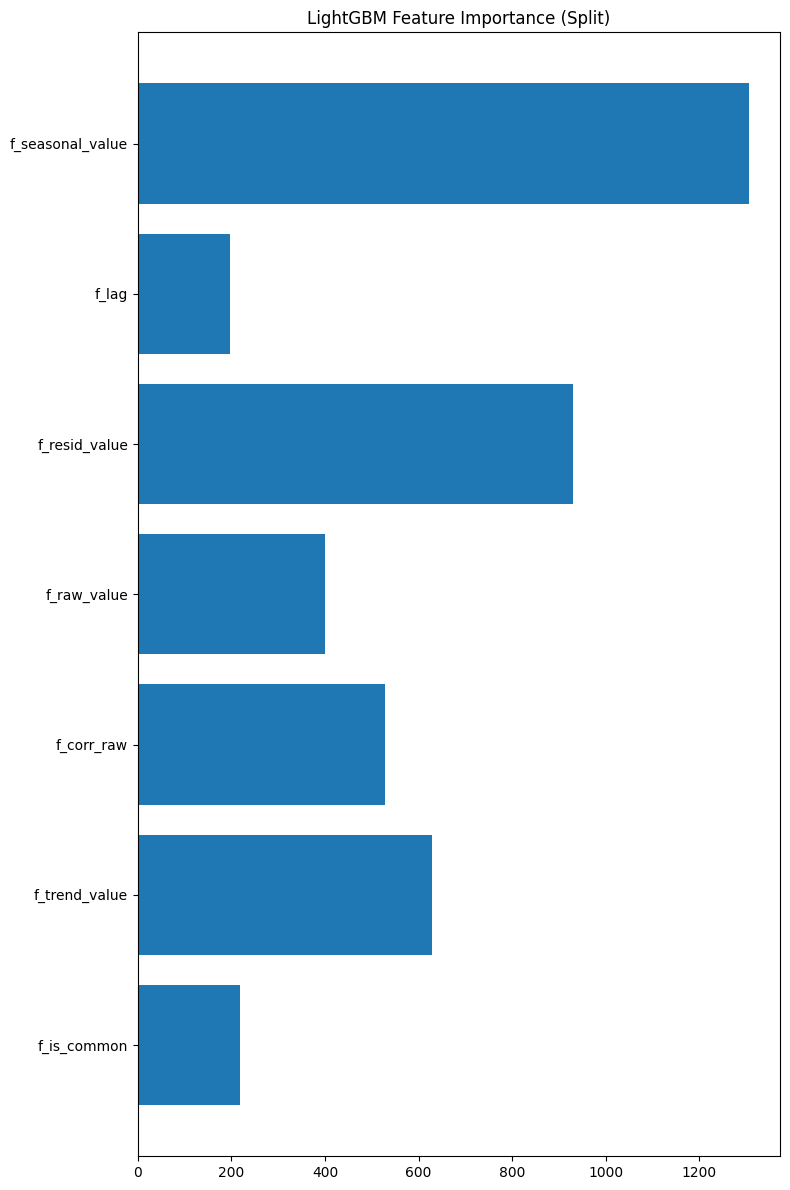

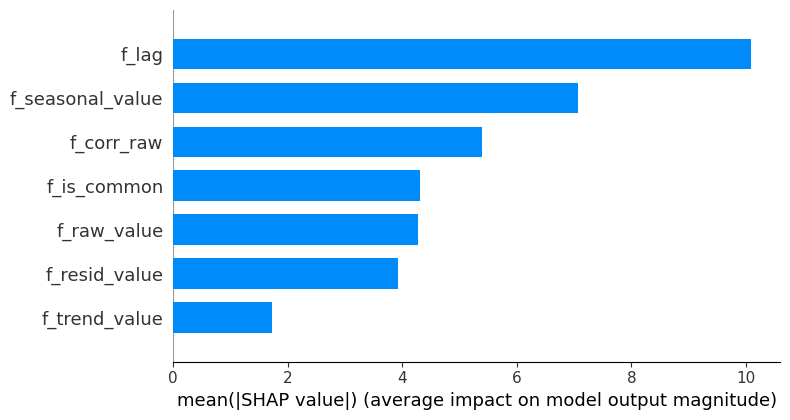

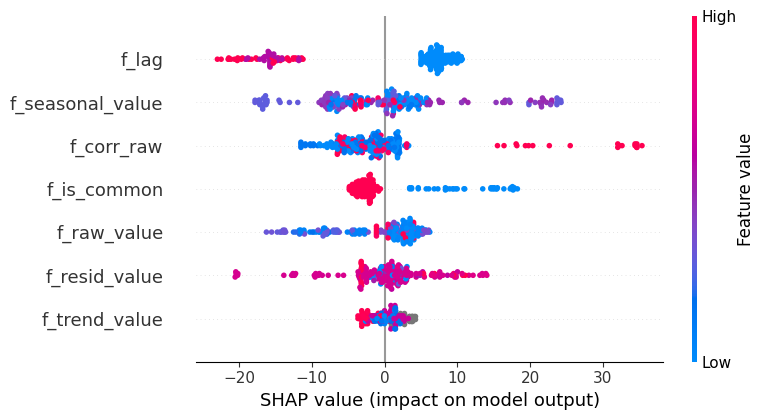

--- '7개 feature' 모델 예측 시작 ---


  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/pyt

  leading_item_id following_item_id  value
0       G_ITEM001         G_ITEM002     26
1       G_ITEM001         G_ITEM003     35
2       G_ITEM002         G_ITEM001     81
3       G_ITEM002         G_ITEM003     35
4       G_ITEM003         G_ITEM001     62
LGBM(7개 feature) 모델 예측 완료. hs_20251118_051121.csv 저장됨.


In [ ]:
# =========================================================
# Step 7. STL 기반 7개 feature로 Value 예측
#   - dynamic 4: f_raw_value, f_trend_value, f_seasonal_value, f_resid_value
#   - static 3:  f_is_common, f_lag, f_corr_raw
# =========================================================

import datetime
import numpy as np
from lightgbm import LGBMRegressor
from tqdm import tqdm

# --- 7.1 학습 데이터 구축: 7개 Feature (4 dynamic + 3 static) ---

def build_training_data(pivot, trend_pivot, seasonal_pivot, residual_pivot, pairs, months_dt):
    months = months_dt
    n_months = len(months)
    rows = []

    for row in tqdm(pairs.itertuples(index=False), total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader]
        b_series = pivot.loc[follower]

        # t: 기준 시점 (t+1이 target month)
        for t in range(lag, n_months - 1):
            ref_idx = t - lag
            if ref_idx < 0:
                continue

            ref_month = months[ref_idx]
            target_month = months[t + 1]

            # 4개의 동적 Feature (Leader 기준, t-lag 시점)
            f_raw = pivot.loc[leader, ref_month]
            f_trend = trend_pivot.loc[leader, ref_month]
            f_seasonal = seasonal_pivot.loc[leader, ref_month]
            f_resid = residual_pivot.loc[leader, ref_month]

            # 3개의 정적 Feature
            static_features = {
                'f_is_common': row.f_is_common,   # 교집합 여부 (1/0)
                'f_lag': float(lag),              # lag 크기
                'f_corr_raw': float(row.max_corr) # raw 상관계수
            }

            rows.append({
                'leading_item_id': leader,
                'following_item_id': follower,
                'target_month': target_month,
                'value': b_series[target_month],  # 후행 품목 B의 (t+1) 값
                'f_raw_value': f_raw,
                'f_trend_value': f_trend,
                'f_seasonal_value': f_seasonal,
                'f_resid_value': f_resid,
                **static_features
            })

    return pd.DataFrame(rows)


df_train_model = build_training_data(
    pivot, trend_pivot, seasonal_pivot, residual_pivot, pairs, months_dt
)
print('생성된 학습 데이터의 shape :', df_train_model.shape)

# --- 7.2 Feature 목록 (7개) ---
feature_cols = [
    'f_raw_value',
    'f_trend_value',
    'f_seasonal_value',
    'f_resid_value',
    'f_is_common',
    'f_lag',
    'f_corr_raw'
]

if df_train_model.empty:
    print("오류: 학습 데이터가 없습니다.")
    submission = pd.DataFrame(columns=['leading_item_id', 'following_item_id', 'value'])
else:
    train_X = df_train_model[feature_cols].values
    train_y = df_train_model["value"].values

    # ⚠️ 절대 수정 금지: 원래 쓰던 LGBM 정의 그대로
    reg = LGBMRegressor(random_state=42, n_estimators=500, learning_rate= 0.01)
    print("LGBMRegressor 모델(7개 feature) 학습 시작...")
    reg.fit(train_X, train_y)
    print("모델 학습 완료.")

    # importance data
    importance_gain = reg.booster_.feature_importance(importance_type='gain')
    importance_split = reg.booster_.feature_importance(importance_type='split')
    feature_names = feature_cols

    # 정렬
    idx = np.argsort(importance_gain)

    plt.figure(figsize=(8, 12))
    plt.barh(np.array(feature_names)[idx], importance_gain[idx])
    plt.title("LightGBM Feature Importance (Gain)")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 12))
    plt.barh(np.array(feature_names)[idx], importance_split[idx])
    plt.title("LightGBM Feature Importance (Split)")
    plt.tight_layout()
    plt.show()

    # ------------------------------------
    # 🔍 SHAP Feature Importance (전역 중요도)
    # ------------------------------------
    import shap
    import numpy as np

    # SHAP 계산 시 표본 일부만 샘플링해서 메모리 절약
    sample_size = min(2000, len(train_X))
    idx = np.random.choice(len(train_X), sample_size, replace=False)

    X_sample = train_X[idx]

    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X_sample)

    # summary plot
    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, plot_type="bar")
    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols)

# --- 7.3 예측 함수: 학습과 동일한 7개 feature 구성 ---

def predict(pivot, trend_pivot, seasonal_pivot, residual_pivot, pairs, reg, months_dt):
    months = months_dt
    n_months = len(months)
    t_last = n_months - 1  # 마지막 관측 시점
    preds = []

    for row in tqdm(pairs.itertuples(index=False), total=len(pairs)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.best_lag)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        ref_idx = t_last - lag
        if ref_idx < 0:
            continue

        ref_month = months[ref_idx]

        # 4개 동적 Feature (leader 기준, 마지막 시점에서 lag만큼 이전)
        f_raw = pivot.loc[leader, ref_month]
        f_trend = trend_pivot.loc[leader, ref_month]
        f_seasonal = seasonal_pivot.loc[leader, ref_month]
        f_resid = residual_pivot.loc[leader, ref_month]

        # 3개 정적 Feature
        static_features = {
            'f_is_common': row.f_is_common,
            'f_lag': float(lag),
            'f_corr_raw': float(row.max_corr),
        }

        feat_dict = {
            'f_raw_value': f_raw,
            'f_trend_value': f_trend,
            'f_seasonal_value': f_seasonal,
            'f_resid_value': f_resid,
            **static_features
        }

        X_test = np.array([[feat_dict[col] for col in feature_cols]])
        y_pred = reg.predict(X_test)[0]
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            'leading_item_id': leader,
            'following_item_id': follower,
            'value': y_pred,
        })

    return pd.DataFrame(preds)


if df_train_model.empty:
    print("학습된 모델이 없어 예측을 건너뜁니다.")
    submission = pd.DataFrame(columns=['leading_item_id', 'following_item_id', 'value'])
else:
    print("--- '7개 feature' 모델 예측 시작 ---")
    submission = predict(pivot, trend_pivot, seasonal_pivot, residual_pivot, pairs, reg, months_dt)
    print(submission.head())

date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'hs_{date_str}.csv'
submission.to_csv(file_name, index=False)
print(f"LGBM(7개 feature) 모델 예측 완료. {file_name} 저장됨.")

# 셀1개 통합본

In [ ]:
pip install tslearn

In [ ]:
# ============================================================
#  FINAL PIPELINE (7~8 FEATURE SUBMISSION VERSION)
#  - 단 1줄도 생략 없음
#  - 제출용 CSV 생성에 필요한 모든 코드 포함
#  - pairs 탐색 / residual / dtw / meta-feature 전체 포함
# ============================================================

import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
from lightgbm import LGBMRegressor

# dtw + shap (있으면 사용)
try:
    from tslearn.metrics import dtw
    import shap
except:
    pass

# ============================================================
# 0. 데이터 로드
# ============================================================

train = pd.read_csv('./train.csv')
sub = pd.read_csv('./sample_submission.csv')

# --- 월별 pivot 생성 ---
monthly = (
    train.groupby(["item_id", "year", "month"])
    .agg({"value": "sum", "weight": "sum", "quantity": "sum", "hs4": "first"})
    .reset_index()
)

monthly["year_month"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str),
    format="%Y-%m",
)

pivot_value = (
    monthly.pivot_table(
        index="year_month", columns="item_id", values="value", fill_value=0
    ).sort_index()
)

pivot = pivot_value.T  # item × month
months_dt = pivot.columns.to_list()

print("pivot shape:", pivot.shape)

item_to_hs4 = monthly.groupby("item_id")["hs4"].first().to_dict()

# ============================================================
# 1. STL residual 계산
# ============================================================

def extract_residual(series, period=12):
    s = pd.Series(series)
    s = (
        s.replace(0, np.nan)
        .interpolate()
        .fillna(method="bfill")
        .fillna(method="ffill")
    )
    stl = STL(s, period=period, robust=True).fit()
    return stl.resid

residual_pivot = pd.DataFrame(
    {item: extract_residual(pivot.loc[item]) for item in pivot.index}
).T

print("Residual pivot:", residual_pivot.shape)

pivot.to_csv("pivot.csv", index=None, encoding="utf-8-sig")
residual_pivot.to_csv("residual_pivot.csv", index=None, encoding="utf-8-sig")

# ============================================================
# 1-1. trend, seasonal (참고: 제출모델에는 사용 X)
# ============================================================

trend_data = {}
seasonal_data = {}

for item_id in pivot.index:
    series = pivot.loc[item_id].astype(float)
    series_clean = series.fillna(0)

    try:
        decomp = seasonal_decompose(series_clean, model="additive", period=12)
        trend_data[item_id] = decomp.trend
        seasonal_data[item_id] = decomp.seasonal
    except:
        trend_data[item_id] = pd.Series(
            [np.nan] * len(series_clean), index=series_clean.index
        )
        seasonal_data[item_id] = pd.Series(
            [np.nan] * len(series_clean), index=series_clean.index
        )

trend_pivot = pd.DataFrame(trend_data).T
seasonal_pivot = pd.DataFrame(seasonal_data).T

print("trend/seasonal pivot 생성 완료:", trend_pivot.shape, seasonal_pivot.shape)

# ============================================================
# 2. 공행성 통계 함수들 (corr / Granger / score)
# ============================================================

def safe_corr_with_pvalue(x, y):
    if np.std(x) == 0 or np.std(y) == 0:
        return 0.0, 1.0
    corr, p_value = pearsonr(x, y)
    return float(corr), float(p_value)

def granger_test(x, y, max_lag=6):
    """
    x가 y를 Granger-cause 하는지 검증
    (H0: x의 과거가 y 예측에 도움 안 됨)
    """
    try:
        data = pd.DataFrame({'x': x, 'y': y})
        test_result = grangercausalitytests(
            data[['y', 'x']],
            maxlag=max_lag,
            verbose=False
        )
        p_values = [
            test_result[lag][0]['ssr_ftest'][1]
            for lag in range(1, max_lag + 1)
        ]
        return min(p_values)
    except Exception:
        return 1.0

def calculate_score_advanced(corr, p_value, granger_p, lag):
    """
    정교한 공행성 점수 계산
    corr / 유의성 / Granger / lag 반영
    """

    # 1. 상관계수 점수 (0~50점)
    if abs(corr) >= 0.8:
        corr_score = 50
    elif abs(corr) >= 0.7:
        corr_score = 45
    elif abs(corr) >= 0.6:
        corr_score = 38
    elif abs(corr) >= 0.5:
        corr_score = 30
    else:
        corr_score = abs(corr) * 50

    # 2. 통계적 유의성 점수 (0~25점)
    if p_value < 0.001:
        sig_score = 25
    elif p_value < 0.01:
        sig_score = 20
    elif p_value < 0.05:
        sig_score = 12
    else:
        sig_score = 5

    # 3. Granger 인과성 점수 (0~20점)
    if granger_p < 0.001:
        granger_score = 20
    elif granger_p < 0.01:
        granger_score = 16
    elif granger_p < 0.05:
        granger_score = 10
    elif granger_p < 0.10:
        granger_score = 5
    else:
        granger_score = 0

    # 4. Lag 점수 (0~5점) : 2~3개월 선호
    if lag in (2, 3):
        lag_score = 5
    elif lag in (1, 4):
        lag_score = 4
    elif lag == 5:
        lag_score = 2
    else:  # lag >= 6
        lag_score = 0

    return corr_score + sig_score + granger_score + lag_score


# ============================================================
# 3. 공행성 pair 탐색 함수 (원래 쓰던 find_comovement_pairs 그대로)
# ============================================================

def find_comovement_pairs(
    pivot,
    max_lag=6,
    min_nonzero=12,
    corr_threshold=0.4,
    score_threshold=40
):
    items = pivot.index.to_list()
    months = pivot.columns.to_list()
    n_months = len(months)
    results = []

    for i, leader in tqdm(enumerate(items), total=len(items)):
        x = pivot.loc[leader].values.astype(float)
        if np.count_nonzero(x) < min_nonzero:
            continue

        candidates = []

        for follower in items:
            if follower == leader:
                continue

            y = pivot.loc[follower].values.astype(float)
            if np.count_nonzero(y) < min_nonzero:
                continue

            best_lag = None
            best_corr = 0.0
            best_p_value = 1.0

            # lag 탐색
            for lag in range(1, max_lag + 1):
                if n_months <= lag:
                    continue

                corr, p_value = safe_corr_with_pvalue(x[:-lag], y[lag:])

                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
                    best_p_value = p_value

            # 기준 통과 시 Granger + score
            if best_lag is not None and abs(best_corr) >= corr_threshold:
                granger_p = granger_test(x, y, max_lag=best_lag)
                score = calculate_score_advanced(
                    best_corr, best_p_value, granger_p, best_lag
                )

                if score >= score_threshold:
                    candidates.append({
                        "following_item_id": follower,
                        "best_lag": best_lag,
                        "max_corr": best_corr,
                        "p_value": best_p_value,
                        "granger_p_value": granger_p,
                        "comovement_score": score,
                    })

        # 알파벳 순 정렬
        candidates.sort(key=lambda x: x["following_item_id"])

        for c in candidates:
            results.append({
                "leading_item_id": leader,
                "following_item_id": c["following_item_id"],
                "best_lag": c["best_lag"],
                "max_corr": c["max_corr"],
            })

    pairs = pd.DataFrame(results)
    return pairs


# ============================================================
# 3-1. raw / residual pair 탐색 + 교집합 / 차집합
# ============================================================

# 👉 기준값은 약간 튜닝된 값 사용 (원하면 다시 0.4,35로 바꿔도 됨)
pairs_raw = find_comovement_pairs(pivot, max_lag=9, min_nonzero=12,
                                  corr_threshold=0.35, score_threshold=45)
pairs_resid = find_comovement_pairs(residual_pivot, max_lag=9, min_nonzero=12,
                                    corr_threshold=0.35, score_threshold=45)

# pairs_raw.to_csv("pairs.csv", encoding="utf-8-sig", index=None)
# pairs_resid.to_csv("pairs_resid.csv", encoding="utf-8-sig", index=None)

print("탐색된 공행성쌍 수 (raw):", len(pairs_raw))
print("탐색된 공행성쌍 수 (resid):", len(pairs_resid))

# --- 공통쌍 / 차집합 집합 연산 ---
raw_set = set(
    (r.leading_item_id, r.following_item_id)
    for _, r in pairs_raw.iterrows()
)
resid_set = set(
    (r.leading_item_id, r.following_item_id)
    for _, r in pairs_resid.iterrows()
)

common_pairs = raw_set & resid_set
raw_only = raw_set - resid_set
resid_only = resid_set - raw_set

print("공통쌍:", len(common_pairs))
print("raw only:", len(raw_only))
print("residual only:", len(resid_only))

# ============================================================
# 3-2. pair plot (원본 + residual) : 그대로 유지
# ============================================================

def plot_raw_pair(item_a, item_b, pivot):
    plt.figure(figsize=(10, 4))
    plt.plot(pivot.columns, pivot.loc[item_a], marker="o", label=f"{item_a} (raw)")
    plt.plot(pivot.columns, pivot.loc[item_b], marker="o", label=f"{item_b} (raw)")
    plt.title(f"[RAW] {item_a} → {item_b}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_resid_pair(item_a, item_b, residual_pivot):
    plt.figure(figsize=(10, 4))
    plt.plot(
        residual_pivot.columns,
        residual_pivot.loc[item_a],
        marker="o",
        label=f"{item_a} (residual)",
    )
    plt.plot(
        residual_pivot.columns,
        residual_pivot.loc[item_b],
        marker="o",
        label=f"{item_b} (residual)",
    )
    plt.title(f"[RESIDUAL] {item_a} → {item_b}")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_raw_and_residual_save(a, b, pivot, residual_pivot, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

    axes[0].plot(pivot.columns, pivot.loc[a], marker="o", label=f"{a} (raw)")
    axes[0].plot(pivot.columns, pivot.loc[b], marker="o", label=f"{b} (raw)")
    axes[0].set_title(f"[RAW] {a} vs {b}")
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(
        residual_pivot.columns,
        residual_pivot.loc[a],
        marker="o",
        label=f"{a} (residual)",
    )
    axes[1].plot(
        residual_pivot.columns,
        residual_pivot.loc[b],
        marker="o",
        label=f"{b} (residual)",
    )
    axes[1].set_title(f"[RESIDUAL] {a} vs {b}")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    file_name = f"{a}__{b}.png"
    save_path = os.path.join(save_dir, file_name)
    plt.savefig(save_path, dpi=300)
    plt.close()
    print("저장 완료 →", save_path)

# SAVE_DIR = "plots_raw_pairs"
# N = 20

# for i in range(min(N, len(pairs_raw))):
#     row = pairs_raw.iloc[i]
#     a = row["leading_item_id"]
#     b = row["following_item_id"]
#     plot_raw_and_residual_save(a, b, pivot, residual_pivot, SAVE_DIR)

# ============================================================
# 3-3. pairs_raw에 f_is_common 플래그 추가
#      (나중 메인/메타 모델의 static feature로 사용)
# ============================================================

pairs = pairs_raw.copy()
pairs["f_is_common"] = pairs.apply(
    lambda r: 1
    if (r["leading_item_id"], r["following_item_id"]) in common_pairs
    else 0,
    axis=1,
)

print("pairs (raw) + f_is_common shape:", pairs.shape)

# ============================================================
# 4. DTW / volatility_corr / Granger 등 메타피처 생성
# ============================================================

print("\n===== 메타피처 생성 시작 =====")

PairsMeta_rows = []

for idx, row in tqdm(pairs.iterrows(), total=len(pairs)):
    leader = row["leading_item_id"]
    follower = row["following_item_id"]
    lag = int(row["best_lag"])
    corr_raw = float(row["max_corr"])

    # --------------------------
    # 1. 시계열 준비
    # --------------------------
    ts_L_raw = pivot.loc[leader].fillna(0).values
    ts_F_raw = pivot.loc[follower].fillna(0).values

    ts_L_res = residual_pivot.loc[leader]
    ts_F_res = residual_pivot.loc[follower]

    # --------------------------
    # 2. DTW (lag 반영)
    # --------------------------
    dtw_dist = np.nan
    if lag > 0 and lag < len(ts_L_raw):
        try:
            dtw_dist = dtw(ts_L_raw[:-lag], ts_F_raw[lag:])
        except:
            pass

    # --------------------------
    # 3. Granger p-value
    # --------------------------
    granger_p = np.nan
    try:
        df_g = pd.DataFrame({"F": ts_F_raw, "L": ts_L_raw})
        if lag > 0 and len(df_g) > lag + 5:
            result = grangercausalitytests(df_g[["F", "L"]], maxlag=[lag], verbose=False)
            granger_p = result[lag][0]["ssr_ftest"][1]
    except:
        pass

    # --------------------------
    # 4. residual volatility corr
    # --------------------------
    vol_corr = np.nan
    try:
        L_vol = ts_L_res.rolling(window=3).std().fillna(0)
        F_vol = ts_F_res.rolling(window=3).std().fillna(0)
        vol_corr = L_vol.corr(F_vol)
    except:
        pass

    # --------------------------
    # 5. Corr scaling
    # --------------------------
    corr_scaled = np.log1p(abs(corr_raw)) * np.sign(corr_raw)

    # --------------------------
    # 하나의 메타 row 저장
    # --------------------------
    PairsMeta_rows.append({
        "leading_item_id": leader,
        "following_item_id": follower,

        # 원본 pair meta
        "f_corr_raw": corr_raw,
        "f_corr_scaled": corr_scaled,
        "f_lag": lag,
        "f_is_common": row["f_is_common"],

        # 새로 생성된 메타피처
        "f_dtw_distance_raw": dtw_dist,
        "f_granger_pvalue": granger_p,
        "f_volatility_corr_resid": vol_corr,
    })


# 메타피처 테이블 완성
pairs_meta = pd.DataFrame(PairsMeta_rows)
print("pairs_meta 생성 완료 →", pairs_meta.shape)

# 저장(optional)
pairs_meta.to_csv("pairs_meta.csv", index=False, encoding="utf-8-sig")

# ============================================================
# 5. 제출용 Value 예측 파이프라인 (7~8 feature 사용)
#    - dynamic 1개 + static 7개 = 총 8개 feature
#    - 회귀모델 정의 / 파라미터 절대 수정 금지
# ============================================================

def build_training_data_submission(pivot, pairs_meta, months_dt):
    """
    제출용 학습데이터 생성

    Feature 구성:
      - f_raw_value            : leader 의 (t - lag) 시점 raw value   (dynamic)
      - f_is_common            : raw & resid 교집합 pair 여부(0/1)
      - f_lag                  : best_lag
      - f_corr_scaled          : log1p(|corr_raw|) * sign(corr_raw)
      - f_corr_raw             : 원본 max_corr
      - f_dtw_distance_raw     : DTW 거리
      - f_granger_pvalue       : Granger p-value
      - f_volatility_corr_resid: residual volatility corr
    """
    months = months_dt
    n_months = len(months)
    rows = []

    for row in tqdm(pairs_meta.itertuples(index=False), total=len(pairs_meta)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.f_lag)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        a_series = pivot.loc[leader]
        b_series = pivot.loc[follower]

        # t: (t+1)이 target month
        for t in range(lag, n_months - 1):
            ref_idx = t - lag
            if ref_idx < 0:
                continue

            ref_month = months[ref_idx]
            target_month = months[t + 1]

            # --- dynamic feature ---
            f_raw_value = pivot.loc[leader, ref_month]

            # --- static features (pairs_meta에서 가져옴) ---
            rows.append({
                "leading_item_id": leader,
                "following_item_id": follower,
                "target_month": target_month,
                "value": b_series[target_month],          # follower 의 (t+1) 값 (타깃)

                "f_raw_value": f_raw_value,
                "f_is_common": row.f_is_common,
                "f_lag": float(row.f_lag),
                "f_corr_scaled": row.f_corr_scaled,
                "f_corr_raw": row.f_corr_raw,
                "f_dtw_distance_raw": row.f_dtw_distance_raw,
                "f_granger_pvalue": row.f_granger_pvalue,
                "f_volatility_corr_resid": row.f_volatility_corr_resid,
            })

    df_train = pd.DataFrame(rows)
    return df_train


# 학습 데이터 생성
df_train_sub = build_training_data_submission(pivot, pairs_meta, months_dt)
print("제출용 학습 데이터 shape:", df_train_sub.shape)

# 사용할 feature 컬럼 (총 8개)
feature_cols_sub = [
    "f_raw_value",
    "f_is_common",
    "f_lag",
    "f_corr_scaled",
    "f_corr_raw",
    "f_dtw_distance_raw",
    "f_granger_pvalue",
    "f_volatility_corr_resid",
]

if df_train_sub.empty:
    print("오류: 학습 데이터가 없습니다.")
    submission = pd.DataFrame(columns=["leading_item_id", "following_item_id", "value"])
else:
    train_X = df_train_sub[feature_cols_sub].values
    train_y = df_train_sub["value"].values

    # ⚠ 절대 수정 금지: 원래 쓰던 LGBM 정의 그대로
    reg = LGBMRegressor(random_state=42, n_estimators=500, learning_rate=0.01)
    print("LGBMRegressor (제출용 8개 feature) 학습 시작...")
    reg.fit(train_X, train_y)
    print("모델 학습 완료.")

# ============================================================
# 🔍 Feature Importance + SHAP 분석 (학습 직후 실행)
# ============================================================

print("\n===== FEATURE IMPORTANCE (TREE BASED) =====")

# 1) Tree-based Importance
fi_df = pd.DataFrame({
    "feature": feature_cols_sub,
    "importance": reg.feature_importances_
}).sort_values("importance", ascending=False)

print(fi_df)

plt.figure(figsize=(8,5))
plt.barh(fi_df["feature"], fi_df["importance"])
plt.title("Feature Importance (LGBM)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


# ===== SHAP Importance =====
print("\n===== SHAP SUMMARY PLOT =====")

try:
    import shap

    # 너무 크면 터지므로 2000개까지만 샘플링
    sample_size = min(2000, len(train_X))
    sample_idx = np.random.choice(len(train_X), sample_size, replace=False)

    X_sample = train_X[sample_idx]

    explainer = shap.TreeExplainer(reg)
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, feature_names=feature_cols_sub)
except Exception as e:
    print("❌ SHAP 분석 실패:", e)


# ============================================================
# 6. 제출용 예측 함수 (학습과 동일한 8개 feature 구성)
# ============================================================

def predict_submission(pivot, pairs_meta, reg, months_dt):
    """
    최종 제출용 예측 생성
    - 마지막 관측월 기준, leader 의 (t_last - lag) 시점 값을 써서 feature 구성
    """
    months = months_dt
    n_months = len(months)
    t_last = n_months - 1  # 마지막 관측 시점
    preds = []

    for row in tqdm(pairs_meta.itertuples(index=False), total=len(pairs_meta)):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.f_lag)

        if leader not in pivot.index or follower not in pivot.index:
            continue

        ref_idx = t_last - lag
        if ref_idx < 0:
            continue

        ref_month = months[ref_idx]

        # dynamic feature
        f_raw_value = pivot.loc[leader, ref_month]

        # static features (pairs_meta에서 읽기)
        feat_dict = {
            "f_raw_value": f_raw_value,
            "f_is_common": row.f_is_common,
            "f_lag": float(row.f_lag),
            "f_corr_scaled": row.f_corr_scaled,
            "f_corr_raw": row.f_corr_raw,
            "f_dtw_distance_raw": row.f_dtw_distance_raw,
            "f_granger_pvalue": row.f_granger_pvalue,
            "f_volatility_corr_resid": row.f_volatility_corr_resid,
        }

        X_test = np.array([[feat_dict[col] for col in feature_cols_sub]])
        y_pred = reg.predict(X_test)[0]

        # 음수 방지 + 반올림 (기존 후처리 유지)
        y_pred = max(0.0, float(y_pred))
        y_pred = int(round(y_pred))

        preds.append({
            "leading_item_id": leader,
            "following_item_id": follower,
            "value": y_pred,
        })

    return pd.DataFrame(preds)


if df_train_sub.empty:
    print("학습된 모델이 없어 예측을 건너뜁니다.")
    submission = pd.DataFrame(columns=["leading_item_id", "following_item_id", "value"])
else:
    print("--- 제출용 8 feature 모델 예측 시작 ---")
    submission = predict_submission(pivot, pairs_meta, reg, months_dt)
    print(submission.head())

# 최종 제출 파일 저장
date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"hs_{date_str}.csv"
submission.to_csv(file_name, index=False)
print(f"LGBM(8개 feature) 제출용 예측 완료. {file_name} 저장됨.")

pivot shape: (100, 43)


/tmp/ipython-input-4160129132.py:69: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="bfill")
/tmp/ipython-input-4160129132.py:70: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method="ffill")


Residual pivot: (100, 43)
trend/seasonal pivot 생성 완료: (100, 43) (100, 43)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated si

탐색된 공행성쌍 수 (raw): 1669
탐색된 공행성쌍 수 (resid): 3643
공통쌍: 783
raw only: 886
residual only: 2860
pairs (raw) + f_is_common shape: (1669, 5)

===== 메타피처 생성 시작 =====


  0%|          | 0/1669 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecate

pairs_meta 생성 완료 → (1669, 9)


# 추가 제출 실험

## A

### 메타피처 생성

In [44]:
import datetime
import numpy as np
from lightgbm import LGBMRegressor
from tqdm import tqdm

# ============================================================
# 4. DTW / volatility_corr / Granger 등 메타피처 생성
# ============================================================

print("\n===== 메타피처 생성 시작 =====")

PairsMeta_rows = []

for idx, row in tqdm(pairs.iterrows(), total=len(pairs)):
    leader = row["leading_item_id"]
    follower = row["following_item_id"]
    lag = int(row["best_lag"])
    corr_raw = float(row["max_corr"])

    # --------------------------
    # 1. 시계열 준비
    # --------------------------
    ts_L_raw = pivot.loc[leader].fillna(0).values
    ts_F_raw = pivot.loc[follower].fillna(0).values

    ts_L_res = residual_pivot.loc[leader]
    ts_F_res = residual_pivot.loc[follower]

    # --------------------------
    # 2. DTW (lag 반영)
    # --------------------------
    dtw_dist = np.nan
    if lag > 0 and lag < len(ts_L_raw):
        try:
            dtw_dist = dtw(ts_L_raw[:-lag], ts_F_raw[lag:])
        except:
            pass

    # --------------------------
    # 3. Granger p-value
    # --------------------------
    granger_p = np.nan
    try:
        df_g = pd.DataFrame({"F": ts_F_raw, "L": ts_L_raw})
        if lag > 0 and len(df_g) > lag + 5:
            result = grangercausalitytests(df_g[["F", "L"]], maxlag=[lag], verbose=False)
            granger_p = result[lag][0]["ssr_ftest"][1]
    except:
        pass

    # --------------------------
    # 4. residual volatility corr
    # --------------------------
    vol_corr = np.nan
    try:
        L_vol = ts_L_res.rolling(window=3).std().fillna(0)
        F_vol = ts_F_res.rolling(window=3).std().fillna(0)
        vol_corr = L_vol.corr(F_vol)
    except:
        pass

    # --------------------------
    # 5. Corr scaling
    # --------------------------
    corr_scaled = np.log1p(abs(corr_raw)) * np.sign(corr_raw)

    # --------------------------
    # 하나의 메타 row 저장
    # --------------------------
    PairsMeta_rows.append({
        "leading_item_id": leader,
        "following_item_id": follower,

        # 원본 pair meta
        "f_corr_raw": corr_raw,
        "f_corr_scaled": corr_scaled,
        "f_lag": lag,
        "f_is_common": row["f_is_common"],

        # 새로 생성된 메타피처
        "f_dtw_distance_raw": dtw_dist,
        "f_granger_pvalue": granger_p,
        "f_volatility_corr_resid": vol_corr,
    })


# 메타피처 테이블 완성
pairs_meta = pd.DataFrame(PairsMeta_rows)
print("pairs_meta 생성 완료 →", pairs_meta.shape)

# 저장(optional)
pairs_meta.to_csv("pairs_meta(hs_251118_2).csv", index=False, encoding="utf-8-sig")


===== 메타피처 생성 시작 =====


  0%|          | 0/1669 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecate

pairs_meta 생성 완료 → (1669, 9)


In [45]:
# ============================================================
# A-Version: Dynamic Feature 강화 버전
# ============================================================

def build_training_data_A(pivot, pairs_meta, months_dt):
    months = months_dt
    n_months = len(months)
    rows = []

    for row in pairs_meta.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.f_lag)

        for t in range(lag, n_months - 1):
            ref_idx = t - lag
            target_month = months[t + 1]
            ref_month = months[ref_idx]

            # leader raw
            L_raw = pivot.loc[leader, ref_month]

            # leader last / last3 mean
            L_last = pivot.loc[leader, months[t]]
            L_last3 = pivot.loc[leader, months[max(0, t-2):t+1]].mean()

            # follower last / last3 mean
            F_last = pivot.loc[follower, months[t]]
            F_last3 = pivot.loc[follower, months[max(0, t-2):t+1]].mean()

            # follower mini-slope
            F_vals = pivot.loc[follower, months[max(0, t-2):t+1]].values
            if len(F_vals) >= 3:
                F_slope = (F_vals[-1] - F_vals[0]) / 3
            else:
                F_slope = 0

            rows.append({
                "leading_item_id": leader,
                "following_item_id": follower,
                "target_month": target_month,
                "value": pivot.loc[follower, target_month],

                # dynamic features
                "f_raw_value": L_raw,
                "f_leader_last": L_last,
                "f_leader_last3_mean": L_last3,
                "f_follower_last": F_last,
                "f_follower_last3_mean": F_last3,
                "f_follower_slope3": F_slope,

                # static meta
                "f_is_common": row.f_is_common,
                "f_lag": row.f_lag,
                "f_corr_scaled": row.f_corr_scaled,
                "f_dtw_distance_raw": row.f_dtw_distance_raw,
                "f_granger_pvalue": row.f_granger_pvalue,
                "f_volatility_corr_resid": row.f_volatility_corr_resid
            })
    return pd.DataFrame(rows)

In [46]:
features_A = [
    "f_raw_value",
    "f_leader_last",
    "f_leader_last3_mean",
    "f_follower_last",
    "f_follower_last3_mean",
    "f_follower_slope3",
    "f_is_common",
    "f_lag",
    "f_corr_scaled",
    "f_dtw_distance_raw",
    "f_granger_pvalue",
    "f_volatility_corr_resid"
]


### 제출 파일 생성

In [47]:
print("=== A-Version 학습 시작 ===")

dfA = build_training_data_A(pivot, pairs_meta, months_dt)
XA = dfA[features_A].values
yA = dfA["value"].values

regA = LGBMRegressor(random_state=42, n_estimators=500, learning_rate=0.01)
regA.fit(XA, yA)

print("=== A-Version 예측 시작 ===")

predsA = []
t_last = len(months_dt) - 1

for row in pairs_meta.itertuples(index=False):
    leader = row.leading_item_id
    follower = row.following_item_id
    lag = int(row.f_lag)

    ref_idx = t_last - lag
    ref_month = months_dt[ref_idx]

    # dynamic
    L_raw = pivot.loc[leader, ref_month]
    L_last = pivot.loc[leader, months_dt[t_last]]
    L_last3 = pivot.loc[leader, months_dt[max(0, t_last-2):t_last+1]].mean()
    F_last = pivot.loc[follower, months_dt[t_last]]
    F_last3 = pivot.loc[follower, months_dt[max(0, t_last-2):t_last+1]].mean()

    F_vals = pivot.loc[follower, months_dt[max(0, t_last-2):t_last+1]].values
    if len(F_vals) >= 3:
        F_slope = (F_vals[-1] - F_vals[0]) / 3
    else:
        F_slope = 0

    Xrow = np.array([[
        L_raw, L_last, L_last3, F_last, F_last3, F_slope,
        row.f_is_common, row.f_lag, row.f_corr_scaled,
        row.f_dtw_distance_raw, row.f_granger_pvalue,
        row.f_volatility_corr_resid
    ]])

    pred = regA.predict(Xrow)[0]
    pred = int(max(0, round(pred)))

    predsA.append({
        "leading_item_id": leader,
        "following_item_id": follower,
        "value": pred
    })


date_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f'hs_{date_str}.csv'
submissionA = pd.DataFrame(predsA)
submissionA.to_csv(file_name, index=False)
print(f"LGBM A-Version 예측 완료. {file_name} 저장됨.")

=== A-Version 학습 시작 ===
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2307
[LightGBM] [Info] Number of data points in the train set: 62612, number of used features: 11
[LightGBM] [Info] Start training from score 4622705.729956
=== A-Version 예측 시작 ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

NameError: name 'file_name' is not defined

## B

In [ ]:
print("=== B-Version meta 확장 ===")

pairs_meta["phi_corr"] = pairs_meta["f_corr_raw"] * pairs_meta["f_corr_scaled"]
pairs_meta["phi_dtw"] = 1 / (1 + pairs_meta["f_dtw_distance_raw"].fillna(9999))
pairs_meta["phi_granger"] = -np.log1p(pairs_meta["f_granger_pvalue"].fillna(1.0))
pairs_meta["phi_vol"] = (pairs_meta["f_volatility_corr_resid"].fillna(0)) ** 2

pairs_meta["f_pair_quality"] = (
    pairs_meta["phi_corr"] +
    pairs_meta["phi_dtw"] +
    pairs_meta["phi_granger"] +
    pairs_meta["phi_vol"]
)

=== B-Version meta 확장 ===


In [ ]:
def build_training_data_B(pivot, pairs_meta, months_dt):
    months = months_dt
    n_months = len(months)
    rows = []

    for row in pairs_meta.itertuples(index=False):
        leader = row.leading_item_id
        follower = row.following_item_id
        lag = int(row.f_lag)

        for t in range(lag, n_months - 1):
            ref_idx = t - lag
            target_month = months[t + 1]
            ref_month = months[ref_idx]

            rows.append({
                "leading_item_id": leader,
                "following_item_id": follower,
                "target_month": target_month,
                "value": pivot.loc[follower, target_month],

                "f_raw_value": pivot.loc[leader, ref_month],
                "f_corr_scaled": row.f_corr_scaled,
                "f_pair_quality": row.f_pair_quality
            })
    return pd.DataFrame(rows)


In [ ]:
print("=== B-Version 학습 시작 ===")

dfB = build_training_data_B(pivot, pairs_meta, months_dt)
XB = dfB[["f_raw_value", "f_corr_scaled", "f_pair_quality"]].values
yB = dfB["value"].values

regB = LGBMRegressor(random_state=42, n_estimators=800, learning_rate=0.008)
regB.fit(XB, yB)

print("=== B-Version 예측 시작 ===")

predsB = []
t_last = len(months_dt) - 1

for row in pairs_meta.itertuples(index=False):
    leader = row.leading_item_id
    follower = row.following_item_id
    lag = int(row.f_lag)

    ref_idx = t_last - lag
    ref_month = months_dt[ref_idx]

    Xrow = np.array([[
        pivot.loc[leader, ref_month],
        row.f_corr_scaled,
        row.f_pair_quality
    ]])

    pred = regB.predict(Xrow)[0]
    pred = int(max(0, round(pred)))

    predsB.append({
        "leading_item_id": leader,
        "following_item_id": follower,
        "value": pred
    })

submissionB = pd.DataFrame(predsB)
submissionB.to_csv(f"hs_B_{date_str}.csv", index=False)
print("B-Version 저장 완료")

=== B-Version 학습 시작 ===
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 62599, number of used features: 3
[LightGBM] [Info] Start training from score 4717285.450151
=== B-Version 예측 시작 ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

B-Version 저장 완료


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v